## Amira Data Challenge - Vahid Khanagha
The task is to use predictions from differnt ASR system to describe how students have pronounced the words in the stories they read. A naive solution is to take ASR outputs as perfect and score the students based on ASR predictions. Two main arguments against this approach can be:

- what if student made an error but ASR Language Model (LM) fixed it
- what if the student didn't make an error, but ASR Acoustic Model (AM) failed to correctly transcribe (due to acoustical conditions, accent, etc)


Some of the related open questions to think about:

- How are the ASR sysyems trained? Do they have a Language Model (LM) trained on in-domain text?
- Is it good to have a LM trained with in-domaon data? Won't it correct student errors? without it, won't the ASR system performance be poor? 

For the task at hand, we can't have the answer to these questions, nor we can make a change to the features we have. So we move on to use these features to build a model. As the naive approach does not seem to be reasonable, we opt for using ensemble learning, to take the opinions of all the four ASR systems into account, hoping that they are meaningfully different systems. 

## Data exploration:
- Each row of `activity_data_100.csv` contains an `expected text` field (which is the same as `golden_transcripts`) which we take as **target** field (so we don't use`story.csv`). We use `expected text` field to create the set of words the student are expected to have pronounced correctly.
- The corresponding ASR systems' predictions seem not to be always aligned with the `expected text` field and they have some extra words before and after the relevant phrase.
- human annotations in `utterance.csv` seem to mark errors with a `abcabc` prefix. But a closer look reveals there seem to be other errors as well: some substitutions and some deletions (compared to the words in `expected text`). We start by looking for both types of `erros`: `substitutions` and `deletions`, and will decide later if `deletions` could be merged or even dropped. 

- The confidence scores from the ASR systems can be more insightful than their ultimate predictions: in the case that one student made an error and ASR LM fixed it, confidence should be low and varry between different systems. This can be an indication of the hidden error.
In the case that student read correctly, ASR made a mistake (AM or LM), ASR systems might be in disagreement, which could be used to discard the false positve (of an error).
In the case that, student read correctly, ASR systems all detected correctly  with high confidence, we may assume no error is made.


## Problem definition
A classifier, classifying each word in the set of ground truth words as `correctly` pronounced, pronounced with `error`, or with `deletion`.


## Alignment of ASR predictions with story phrases
As mentioned above, ASR predictions are not perfectly aligned with the target text in `expected text` field. There are some rows in `activity_data_100.csv`, where `kaldi_text` has some extra words before and after the part that corresponds to the target text. Fort instance, in the below example, `kaldi text` seeem to completely cover the story text in the `expected text` field, but there are several words before and after the phrase of interest.

- story text:  `he even called the other kids names and stole their snacks`
- kaldi text:  `he stole the led called skid he even called the other kids names and stole their snacks other kids`

This might be because ASR systems are fed with audio that covered a bit of audio before and after the exact time the `expected text` was uttered.
In order to use ASR systems outputs for the task at hand, we first need to align these utterances. Only then we can propperly use the confidence scores to perform pronounciation assesment.

We use the edit distance sequence matching approach to make this alignment. The sequence matcher, matches the two sequences such that the total number of mismatches are minimized. This seems to be a reasonable approach for finiding out how best ASR ouputs can be aligned to the phrases in `expected text`.

## Alignment of word-level human annotations, to the aligned texts
Once ASR outputs are trimmed to align with `expected text`, we face a second sequence matching problem in using human annotations to build a classifier. Human annotations are made on word level and can only be tied to the activites df through `activityID`. But how do we pair the words in  `utterance.csv` with the words from ASR system (matched to `expected text`)?

Once again we use edit-distance-based sequence matching to find the best possible alignment between all of the words annotated for each `activityID` and the words from ASR system outputs. 
This time, we face a challenge that some of the words that should be aligned, are not actually matching. For instance, `names` might be annotated as `abcabcname`. For this reason, a more relaxed definition of "matching" is used for edit-distance-based sequence mathcing. In this case, we take "partially" equivalent strings to be considered as "matches" and be aligned with each other.



In [1]:
# !pip install edit_distance pandas matplotlib numpy sklearn
import ast
import string
import edit_distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# helper functions
def normalize_text(txt):
    """basic text normalization operations
    ------
    inputs: 
        txt(str) : a string to be standardized
    returns:
        new_txt(str): standardized text
    """
    # remove capitalization
    new_txt = txt.strip().lower()

    # remove punctuations
    new_txt = new_txt.translate(str.maketrans('', '', string.punctuation))
    return new_txt

def normalize_df_column(col_str):
    """ a lambda function, to apply normalize_text to different columns of 
    the act_df. Some columns are string representations of lists and
    dictionaries that are converted to the original data type.
    Other columns are plain text, and are normalized.
    
    Inputs: col_str(str) : the value from one column that needs to be standardized
    """
    new_val = ""
    if isinstance(col_str, str):  #some nan values exist
        if '[' in col_str:  # [ is taken as an indication of a data structure
            new_val = ast.literal_eval(col_str)
        else:
            new_val = normalize_text(col_str)
    return new_val

def align_with_gold(ref, hyp, confids):
    """
    Takes SR output and alignes it with the refference (expected text) using
    edit_distance.
    ----
    Inputs:
        ref(str): a string containing expected text
        hyp(str): a string containing ASR system output
        confids[list]: a list of lists, or tuples. The list is indexed in parallel
            with hyp, and for each word in hyp, it contains a [word, confidence] pair of
            info
        targets[dict]: a dictionary with all word in ref as keys, and the values that contain
            the info about whether the word was:
                - correctly detected ==> confidenc_Value (positive float value)
                - deleted ==> -4 (large negatiev value)
                - substituted ==> - confidence_value
            substituted by the ASR system. (negative float value)
            ex: {'adam': 0.98, 'was': -4, "sad": -0.75} means:
                 'adam' is correctly detected, 'was' is deleted, 
                  and 'sad' is replaced (we don't care with what for now)
    
    """
    ref_list = ref.split(" ")
    hyp_list = hyp.split(" ")
    _, _, opcodes = edit_distance.edit_distance_backpointer(ref_list, hyp_list)
    targets = {}
    for op in opcodes:
        if op[0] != 'insert':
            if op[0] == 'equal':
                targets[ref_list[op[1]]] = round(confids[op[3]][1], 2)
            elif op[0] == 'replace':
                if len(confids) > op[3]:
                    targets[ref_list[op[1]]] = - round(confids[op[3]][1], 2)
                else:
                    # edge case when asr returns no word at all (no confidence)
                    targets[ref_list[op[1]]] = -4 # it's a deletion 
            else:
                targets[ref_list[op[1]]] = -4 # deletion
    return targets

In [3]:
# not using story.csv and activities.csv. Allign records using activity_data_100.csv
act_df = pd.read_csv('activity_data_100.csv')
utt_df = pd.read_csv('utterance.csv')

In [4]:
# Standardize all text columns
# + Change data type of cols with stringed data strucuture to usable format
norm_cols = ['kaldi_text', 'kaldi_transcription', 'google_output',
             'pocketsphinx_transcript', 'pocketsphinx_word_confidence',
             'amazon_transcript', 'amazon_word_confidence', 'amazon_word_lapse',
             'amazon_frame_interval', 'expected text', 'golden transcript']
for c in norm_cols:
    act_df[c] = act_df[c].apply(lambda x: normalize_df_column(x))

# prepare google columns
# not sure what's the difference between google_confidence_0 and google_confidence_1. They look the same
act_df['google_confidence_0'] = act_df['google_output'].apply(lambda x: x[1])
act_df['google_confidence_1'] = act_df['google_output'].apply(lambda x: x[2])
act_df['google_output'] = act_df['google_output'].apply(lambda x: normalize_text(x[0]))

# prepare kaldi confidence scores
act_df['kaldi_confids'] = act_df['kaldi_transcription'].apply(lambda x: [[xk['word'], xk['confidence']] for xk in x])

# align ASR outputs with "expected text" field and generate word-level scores
act_df['google_scores'] = act_df.apply(lambda row: align_with_gold(row['expected text'],
                                                                   row['google_output'],
                                                                   row['google_confidence_1']),axis=1)
act_df['amazon_scores'] = act_df.apply(lambda row: align_with_gold(row['expected text'],
                                                                   row['amazon_transcript'],
                                                                   row['amazon_word_confidence']), axis=1)
act_df['pocketsphinx_scores'] = act_df.apply(lambda row: align_with_gold(row['expected text'],
                                                                         row['pocketsphinx_transcript'],
                                                                         row['pocketsphinx_word_confidence']), axis=1)
act_df['kaldi_scores'] = act_df.apply(lambda row: align_with_gold(row['expected text'],
                                                                  row['kaldi_text'],
                                                                  row['kaldi_confids']), axis=1)


#### Few examples of phrase alignment:

In [5]:
for k in [111, 222, 333]:
    print('======================================================')
    print('story text: ', act_df.loc[k]['expected text'])
    print('--- google: ', act_df.loc[k]['google_output'])
    print('--- scores for aligned words: ',act_df.loc[k]['google_scores'])
    print('                 -----------------------               ')
    print('@@@@ amazon: ', act_df.loc[k]['amazon_transcript'])
    print('@@@@ scores for aligned words: ', act_df.loc[k]['amazon_scores'])
#     print('                 -----------------------               ')
#     print('+++ kaldi: ', act_df.loc[k]['kaldi_text'])
#     print('+++ scores for aligned words: ', act_df.loc[k]['kaldi_scores'])
#     print('                 -----------------------               ')
#     print('#### pocketsphinx: ', act_df.loc[k]['pocketsphinx_transcript'])
#     print('#### scores for aligned words: ',act_df.loc[k]['pocketsphinx_scores'])


story text:  he even called the other kids names and stole their snacks
--- google:  from here so no one could swim he even called the other kids stage and stole their snacks all the kids
--- scores for aligned words:  {'he': 0.9, 'even': 0.9, 'called': 0.9, 'the': 0.9, 'other': 0.9, 'kids': 0.9, 'names': -0.9, 'and': 0.9, 'stole': 0.9, 'their': 0.9, 'snacks': 0.9}
                 -----------------------               
@@@@ amazon:  huh street from here so does a wad kind sweet he even called the other kids daves installed their stacks all the kids
@@@@ scores for aligned words:  {'he': 1.0, 'even': 1.0, 'called': 1.0, 'the': 1.0, 'other': 1.0, 'kids': 0.81, 'names': -0.73, 'and': -0.95, 'stole': -1.0, 'their': -1.0, 'snacks': -1.0}
story text:  mary said recess should be like this every day
--- google:  princess mary said reeses should be like this every day
--- scores for aligned words:  {'mary': 0.73, 'said': 0.73, 'recess': -0.73, 'should': 0.73, 'be': 0.73, 'like': 0.73, 'this': 

#### Create a new dataframe containing word-level asr predictions:

In [6]:
words_df = pd.DataFrame(columns=['activityId', 'word', 'kaldi_score', 'google_score', 'amazon_score', 'pocketsphinx_score'])
for index, row in act_df.iterrows():
    words = row['kaldi_scores'].keys()
    for w in words:
        wrow = [row['activityId'], w, row['kaldi_scores'][w],
                row['google_scores'][w], row['amazon_scores'][w], row['pocketsphinx_scores'][w]]
        words_df.loc[len(words_df)] = wrow

# standardize activityIDs:
words_df['activityId'] = words_df['activityId'].apply(lambda x: x[:-4])
utt_df['activityId'] = utt_df['activityId'].apply(lambda x: x[:-4])

words_df.head(5)

,activityId,word,kaldi_score,google_score,amazon_score,pocketsphinx_score
0,017CDA554B3311E9BEA916071609,every,1,-4,0.80,1
1,017CDA554B3311E9BEA916071609,day,1,-0.9,0.80,1
2,017CDA554B3311E9BEA916071609,during,1,0.9,1.00,1
3,017CDA554B3311E9BEA916071609,recess,0.99,0.9,0.98,1
4,017CDA554B3311E9BEA916071609,mary,1,0.9,0.82,1


#### Create labels for classification task:
For each unique `activityId`, we align the seqeuence of words from human annotation csv file (`utt_df`) to the expected list of words taken from `expected test` field. Given that most of words are correctly pronounces, the alignment implicitly aiging the errors too. We can then compare word by word, and take the ones that do not match as errors. 
We discard extra words introduced by human annotators (insertions) as they do not seem to be relevant to our task.

In [ ]:
# initial dummy values
words_df['label'] = True
words_df['annotated_word'] = ""
words_df['extra_annotated_word'] = ""

unique_activity_ids = words_df.activityId.unique()

# convert dataframes to records, for sequence alignment
utt_recs = utt_df.to_dict('records')
words_recs = words_df.to_dict('records')

def edit_test(a,b):
    """
    this function is used to overried the "==" operator for sequence matching.
    Apart from the basic definition of equality(a==b), a loose notion of equality
    is also used, so that partial word matches can also be aligned. Few example
    pairs of partial matches: ('name', 'names'), ('book','ababcbook'), ....
    
    Inputs:
        a,b (str): to string to be compared. Returns True if they match.
    """
    loose_criteria = ((b[:-1] in a) or (a[:-1] in b)) and len(a) > 3 and len(b) > 3
    if a==b or a in b or b in a or loose_criteria:
        return True
    else:
        return False

for id in unique_activity_ids:
    # take list of all annotated words for this id. Remove blank "   "s.
    annotator_words = [x['Utterance'] for x in utt_recs if x['activityId'] == id]
    annotator_words = [w for w in annotator_words if len(w.replace(' ', '')) > 0]
    
    # take all expected words for current id
    ref_words = [x['word'] for x in words_recs if x['activityId'] == id]
    
    # perform a loose sequence matching
    sm = edit_distance.SequenceMatcher(ref_words,  annotator_words, test = edit_test)
    opcodes = sm.get_opcodes()
    
    # the begining index in the original dataframe, to offset thw opcodes
    beg_index = words_df[words_df['activityId'] == id].index[0]
    
    for op in opcodes:
        if op[0] == 'equal':
            words_df.loc[beg_index + op[1], 'annotated_word'] = annotator_words[op[3]]
            if ref_words[op[1]] == annotator_words[op[3]]:
                words_df.loc[beg_index + op[1], 'label'] = 'correct'
            else:
                words_df.loc[beg_index + op[1], 'label'] = 'error'
        elif op[0] == 'replace':
            if 'abc' in annotator_words[op[3]]:
                words_df.loc[beg_index + op[1], 'label'] = 'error'
            else:
                words_df.loc[beg_index + op[1], 'label'] = 'error'
            words_df.loc[beg_index + op[1], 'annotated_word'] = annotator_words[op[3]]
        elif op[0] == 'insert':
            words_df.loc[beg_index + op[1], 'extra_annotated_word'] = annotator_words[op[3]]
        else:
            words_df.loc[beg_index + op[1], 'annotated_word'] = ""
            words_df.loc[beg_index + op[1], 'label'] = "del"
    

In [16]:
words_df.head(60)

,activityId,word,kaldi_score,google_score,amazon_score,pocketsphinx_score,label,annotated_word,extra_annotated_word
0,017CDA554B3311E9BEA916071609,every,1,-4,0.80,1,correct,every,
1,017CDA554B3311E9BEA916071609,day,1,-0.9,0.80,1,correct,day,
2,017CDA554B3311E9BEA916071609,during,1,0.9,1.00,1,correct,during,
3,017CDA554B3311E9BEA916071609,recess,0.99,0.9,0.98,1,correct,recess,
4,017CDA554B3311E9BEA916071609,mary,1,0.9,0.82,1,correct,mary,
5,017CDA554B3311E9BEA916071609,jason,1,0.9,1.00,1,correct,jason,
6,017CDA554B3311E9BEA916071609,and,1,0.9,1.00,1,correct,and,
7,017CDA554B3311E9BEA916071609,their,1,0.9,0.97,1,correct,their,
8,017CDA554B3311E9BEA916071609,classmates,1,0.9,1.00,1,correct,classmates,
9,017CDA554B3311E9BEA916071609,played,1,-0.9,0.97,1,correct,played,


### Feature exploration:
No that we have a complete dataset, we can analyze the data to get some intuition about how we can build a model. Lets look at the distribution of scores, for the three label categories: `error`, `correct` and `del`. Note that densities are plotted instead of simple histogram so that the much more frequent `correct` class would not dominate the plot.

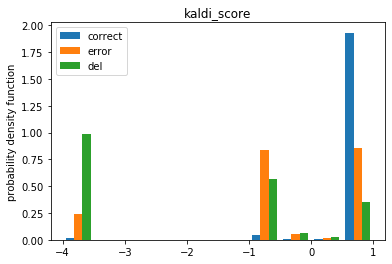

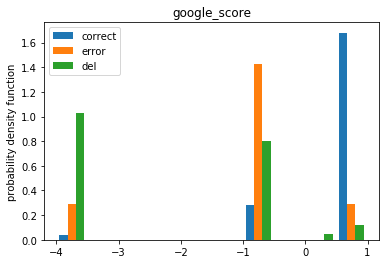

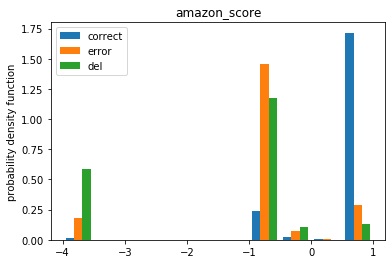

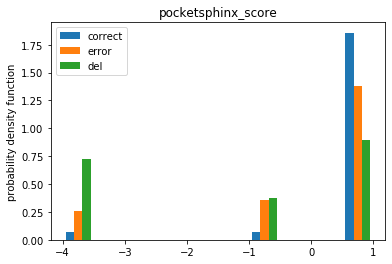

In [10]:
categories = words_df.label.unique()
scores = ['kaldi_score', 'google_score', 'amazon_score','pocketsphinx_score']

for sc in scores:
    plt.hist([words_df.loc[words_df.label == x, sc] for x in categories],
             label=categories, density=True, bins = 10)
    plt.legend()
    plt.title(sc)
    plt.ylabel('probability density function')
    plt.show()

From the plots, it can be seen that the scores can indeed be useful for the classification task at hand. Most of the `correct` words have higher confidence values around `1`, while the `errors` seem to be having lower, and even negative, values of confidence. The `deletion` cases have also got the extreme negative value assigned to them during data preparation (`-4`).

#### Create training and testing dataset splits:

In [19]:
SCORES = ['kaldi_score', 'google_score', 'amazon_score', 'pocketsphinx_score']
dataset_df = words_df[SCORES + ['label']].copy()
dataset_df['n_asr_del'] = 0
for sc in SCORES:
    # for each ASR score < -3, count one deletion
    dataset_df['n_asr_del'] = dataset_df.apply(lambda r: r['n_asr_del'] + 1 if r[sc] < -3 else r['n_asr_del'],
                                               axis=1)
    # clip deletion values of -4 to -1, so that they are just an error, not having a large negative value
    dataset_df[sc] = dataset_df[sc].clip(-1, 1)
df_train, df_test = train_test_split(dataset_df,stratify=words_df['label'], test_size=0.15)
df_train.head(30)

,kaldi_score,google_score,amazon_score,pocketsphinx_score,label,n_asr_del
2579,1,0.94,1.00,1,correct,0
15349,1,0.93,1.00,1,correct,0
16716,1,0.93,1.00,1,correct,0
23869,1,0.93,1.00,1,correct,0
21078,1,0.9,1.00,1,correct,0
14693,1,0.94,1.00,1,correct,0
23646,1,0.79,1.00,1,correct,0
3510,1,0.94,1.00,1,correct,0
22811,1,0.93,0.98,-1,correct,0
3346,1,0.89,-1.00,1,correct,0


### Rule-based approach
As a first attempt, we can try to implement a simple rule-based majority voting based approach.
For each word, if the majority of confidence scores were above a thershold, we take them as `correct`ly detected. The thresholds for each ASR system are automatically computed as 20% percentile of each score. 
Given that in the score generation step, we assigned the extreme negative value of -4 to the deleted words, the second rule counts such cases and if the majority of ASR systems had detected a deletion, we classify as a `del`etion. All other words that are neither correctely detected nor deleted are considered as `error`.

In [12]:
def classify(row_dict, sc_th):
    """
    A rule-based majority-voting classifier, that for every key in row_dict
    uses the corresponding thresold in the sc_th dictionary and counts the number 
    of deletions and correct detections. Based on these counts, the final classification
    if performed.
    
    Returns: One of the three labels: 'error', 'del', 'correct'
    """
    n_correct = 0
    n_del = 0
    for sc in SCORES:
        if row_dict[sc] > sc_th[sc]:
            n_correct += 1
        elif row_dict[sc] < - 3.5:
            n_del += 1
    if n_correct >= 2:
        return "correct"
    elif row_dict['n_asr_del'] >= 2:
        return "del"
    else:
        return "error"

# automated generation of thresholds form the training dataset
percentile_th = 0.2
margin = 0.01
sc_correct_th = {}
for sc in SCORES:
    sc_correct_th[sc] = df_train[df_train['label']=='correct'][sc].quantile(percentile_th) - margin

# lets test the classifier first on train set (for parameter tunning maybe)
print('------------------ Train set accuracy:')
prediction = df_train.apply(lambda r: classify(r, sc_correct_th), axis=1)
print(classification_report(df_train['label'], prediction))
print('confusion matrix:\n', confusion_matrix(df_train['label'], prediction))

# After parameter tunning measure the performance on the test set.
print('------------------ Test set accuracy:')
prediction = df_test.apply(lambda r: classify(r, sc_correct_th), axis=1)
print(classification_report(df_test['label'], prediction))
print('confusion matrix:\n ', confusion_matrix(df_test['label'], prediction))

------------------ Train set accuracy:
              precision    recall  f1-score   support

     correct       0.98      0.96      0.97     18678
         del       0.81      0.48      0.60      1425
       error       0.25      0.61      0.35       722

    accuracy                           0.91     20825
   macro avg       0.68      0.68      0.64     20825
weighted avg       0.94      0.91      0.92     20825

confusion matrix:
 [[17853    82   743]
 [  128   686   611]
 [  198    83   441]]
------------------ Test set accuracy:
              precision    recall  f1-score   support

     correct       0.98      0.96      0.97      3296
         del       0.82      0.52      0.64       251
       error       0.28      0.69      0.40       128

    accuracy                           0.92      3675
   macro avg       0.70      0.72      0.67      3675
weighted avg       0.95      0.92      0.93      3675

confusion matrix:
  [[3149   15  132]
 [  26  131   94]
 [  27   13   88]]


Test set accuracies are not too bad. Specially that the recall value for the target class is high (`0.63`). The low precision is partly due to the `error` --> `del` type of errors. If we take a deletion as an error, the accuracy will be much higher. We will see this at the end of these experiments. Bur for now lets try few other simple classifiers. 
### Random Forest clasisfication

In [13]:
X = df_train[SCORES + ['n_asr_del']]
y = df_train['label']
clf = RandomForestClassifier(n_estimators=100, max_depth=5,
                             random_state=0, class_weight={'correct':0.2,
                                                           'del':0.2,
                                                           'error':0.8})
clf.fit(X, y)
y_pred = clf.predict(df_test[SCORES+ ['n_asr_del']])
print('------------------ Test set accuracy:')
print(classification_report(df_test['label'], y_pred))
print(confusion_matrix(df_test['label'], y_pred))

------------------ Test set accuracy:
              precision    recall  f1-score   support

     correct       0.98      0.98      0.98      3296
         del       0.84      0.55      0.66       251
       error       0.35      0.59      0.44       128

    accuracy                           0.94      3675
   macro avg       0.72      0.70      0.69      3675
weighted avg       0.95      0.94      0.94      3675

[[3228   12   56]
 [  33  137   81]
 [  39   14   75]]


Random forest slightly improved the results. But we still observe the same trend of `error` --> `del` type of error.

### Logistic Regression classifier:

In [14]:
X = df_train[SCORES + ['n_asr_del']]
y = df_train['label']
clf = LogisticRegression(random_state=0, class_weight={'correct':0.2,
                                                       'del':0.2,
                                                       'error':.9})
clf.fit(X, y)
y_pred = clf.predict(df_test[SCORES+ ['n_asr_del']])
print(classification_report(df_test['label'], y_pred))
print(confusion_matrix(df_test['label'], y_pred))
print('LR coefficients: ', clf.coef_)

              precision    recall  f1-score   support

     correct       0.98      0.98      0.98      3296
         del       0.83      0.42      0.56       251
       error       0.29      0.59      0.39       128

    accuracy                           0.92      3675
   macro avg       0.70      0.66      0.64      3675
weighted avg       0.94      0.92      0.93      3675

[[3216   10   70]
 [  34  105  112]
 [  41   12   75]]
LR coefficients:  [[ 0.8894044   0.62931467  0.66542245  0.26383234 -0.05224864]
 [-0.57551363 -0.28250031 -0.3241548  -0.20877452  0.31194678]
 [-0.31389077 -0.34681436 -0.34126764 -0.05505782 -0.25969813]]


The performance of Logistic Regression classifier is very close to the Random forest one. Lets focus on `error` --> `del` type of error, by mapping all instances of `del` to `error`, and retrain our best classifier.

### Two-class Random Forest classifer:

In [15]:
X = df_train[SCORES + ['n_asr_del']]
y = df_train['label'].copy()
# convert all `del` labels to `error`
y[y=='del']='error'
clf = RandomForestClassifier(n_estimators=100, max_depth=5,
                             random_state=0, class_weight={'correct':0.2,
                                                           'error':0.8})
clf.fit(X, y)
y_test = df_test['label'].copy()
y_test[y_test=='del']='error'
y_pred = clf.predict(df_test[SCORES+ ['n_asr_del']])
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

     correct       0.98      0.97      0.97      3296
       error       0.74      0.85      0.79       379

    accuracy                           0.95      3675
   macro avg       0.86      0.91      0.88      3675
weighted avg       0.96      0.95      0.96      3675

[[3183  113]
 [  56  323]]


It can be seen that the performance is significantly improved by merging the two classes `del` and `error`. This suggests that:
- Our data preparation could be revisited, making sure that we are not labeling errors as deletions.
- The annotators might not have entered a word for some errors. In this case, the ASR systems generate a low-confidence output (as in an error), but the label generated from human annotation is `del` because the word is missing.

This certainly necessiated further data analysis to understand and probably debug the current data preparation operations.



### Future work:
- revisit data preparation steps, deeg deeper to remove any erroneous labels from the dataset
- in-depth error analysis to understand the trends and potential errors
- get a better understanding about the 4 different ASR systems, how they are trained and what datasets are used for training them.
- literature review/peer discussion to understand prior works
- parameter tunning and grid search for the classifiers
- consider alternative approaches, such as training a phonetic recognizer rather than an LM backed ASR system. An e2e phonetic recognizer will require phone-level pattern matching which is a challenging task and prone to error in absence of an LM. 